# Project 24 - Optimizing Model Prediction

On [previous projects](https://github.com/SanteriIsotalo/Dataquest_Projects) the focus was on constructing a single model and implementing the various ideas learned in that [Dataquest](https://www.dataquest.io) course. For this project, we'll take a different approach: Instead of going with a single model, we'll start with a reference model and then iterate on it using different techniques.
<b>Our reference model will be a standard linear regression model, and our machine learning task will be to predict the extent of fire damage to a forest.</b> Our data comes from the [Forest Fires dataset from the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

# Reading in the Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fires = pd.read_csv('fires.csv', index_col=0)
print(fires.shape)
fires.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


From the documentation we can see that the columns mean the following:
|Column name|Description|
|-----------|-----------|
|X|x-axis spatial coordinate within the Montensinho park map: 1 to 9|
|Y|y-axis spatial coordinate within the Montensinho park map: 2 to 9|
|month|month of the year, 'jan' to 'dec'|
|day|day of the week 'mon' to 'sun'|
|FFMC|FFMC index from the FWI system: 18.7 to 96.20|
|DMC|DMC index from the FWI system: 1.1 to 291.3|
|DX|DC index from the FWI system: 7.9 to 860.6|
|ISI|ISI index from the FWI system: 0.0 to 56.10|
|temp| temperature: 2.2 to 33.3 (Celsius degrees)|
|RH | relative humidity: 15 to 100 (%)|
|wind| wind speed 0.4 to 9.4 (km/h)|
|rain| outside rain: 0.0 to 6.4 (mm/mm2)|
|area| the burned are of the forest: 0.00 to 1090.84 (ha) |

## Data Processing

Next we are going to clean our data. I will go through each column and check if there is something that should be fixed.

### X and Y

In [2]:
print(fires['X'].isnull().sum())
print(fires['Y'].isnull().sum())
print(fires['X'].value_counts().sort_index())
print(fires['Y'].value_counts().sort_index())

0
0
X
1    48
2    73
3    55
4    91
5    30
6    86
7    60
8    61
9    13
Name: count, dtype: int64
Y
2     44
3     64
4    203
5    125
6     74
8      1
9      6
Name: count, dtype: int64


X and Y columns have no null values, and all of the values seem to be correct (X from 1 to 9, Y from 2 to 9)

### Month and Day

In [3]:
print(fires['month'].isnull().sum())
print(fires['day'].isnull().sum())
print(f"months: {fires['month'].unique()}")
print(f"days: {fires['day'].unique()}")

0
0
months: ['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov']
days: ['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu']


These values seem to be correct, but to use them in our model we need to change them to numerical values. I will change months from 1 to 12 and days from 0 to 6.

In [4]:
#removing warnings
pd.set_option('future.no_silent_downcasting', True)

fires['day'] = fires['day'].replace({'mon': 0,
                                    'tue': 1,
                                    'wed': 2,
                                    'thu': 3,
                                    'fri': 4,
                                    'sat': 5,
                                    'sun': 6}).astype('int')
fires['month'] = fires['month'].replace({'jan': 1,
                                         'feb': 2,
                                         'mar': 3,
                                         'apr': 4,
                                         'may': 5,
                                         'jun': 6,
                                         'jul': 7,
                                         'aug': 8,
                                         'sep': 9,
                                         'oct': 10,
                                         'nov': 11,
                                         'dec': 12}).astype('int')
print(f"months: {fires['month'].unique()}")
print(f"days: {fires['day'].unique()}")

months: [ 3 10  8  9  4  6  7  2  1 12  5 11]
days: [4 1 5 6 0 2 3]


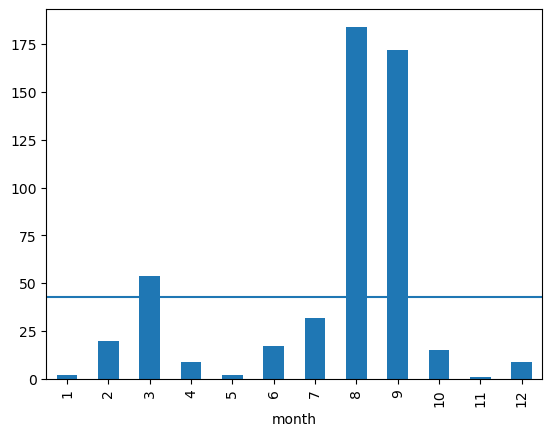

In [5]:
fires['month'].value_counts().sort_index().plot(kind='bar')
plt.axhline(fires['month'].value_counts().mean())
plt.show()

We can see that most fires occur during August and September. I thought about changing `months` to `summer` with either 0 for no and 1 for yes to get around 50/50 yes and no values (September is not summer), but I'll skip that at least for now. Let's check are the days equally distributed.

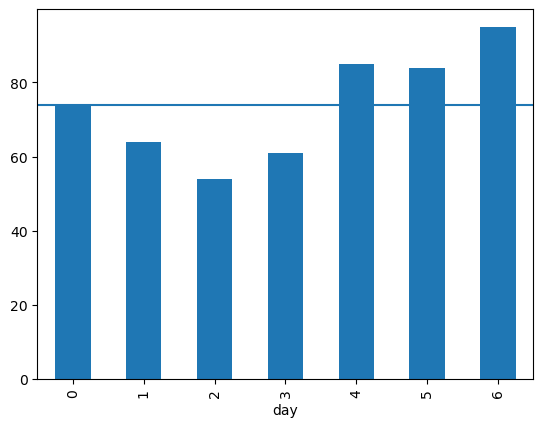

In [6]:
fires['day'].value_counts().sort_index().plot(kind='bar')
plt.axhline(fires['day'].value_counts().mean())
plt.show()

From the plot above we can see that there are more fires during weekends (Friday, Saturday and Sunday) than during weekdays. I will change the `day` column to `weekend` with `1` for `True` and `0` for `False`.

In [7]:
fires['day'] = fires['day'].apply(lambda x: 1 if x in [4,5,6] else 0)
fires = fires.rename(columns = {'day': 'weekend'})
fires.sample(5)

,X,Y,month,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
296,7,5,6,1,93.1,180.4,430.8,11.0,22.2,NaN,1.3,0.0,0.00
208,7,5,9,0,91.0,129.5,692.6,7.0,20.7,37.0,2.2,0.0,17.20
494,1,3,8,1,95.9,158.0,633.6,11.3,27.5,29.0,4.5,0.0,43.32
396,4,5,2,1,85.0,9.0,56.9,3.5,10.1,62.0,1.8,0.0,51.78
287,7,6,7,0,91.2,183.1,437.7,12.5,12.6,90.0,7.6,0.2,0.00


## FFMC

In [8]:
print(fires['FFMC'].isnull().sum())

48


There are 48 null values in the `FFMC` column. Our whole dataset has 517 rows, so deleting these would remove almost 10% of our data.

FFMC mean value is: 90.58038379530916


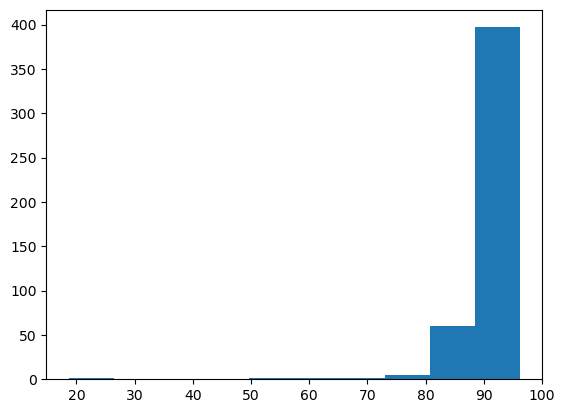

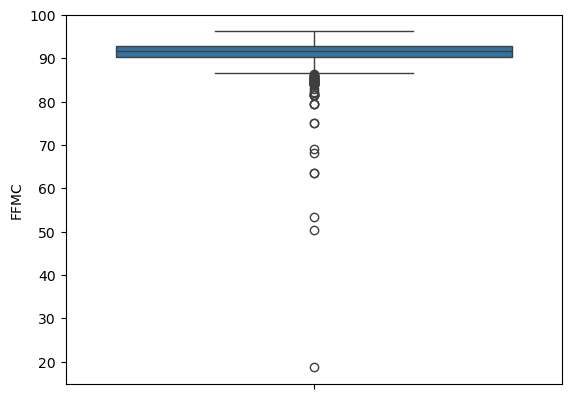

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
print(f"FFMC mean value is: {fires['FFMC'].mean()}")

plt.hist(fires['FFMC'])
plt.show()

sns.boxplot(data=fires['FFMC'])
plt.show()

From the histogram we can see that almost all values are between 80 and 100. The distribution is very left skewed. If we get the mean value for this column, we get 90.58. I will assign this mean value to all the missing values. We can also see that there are multiple outliers, but one is a very clear outlier (value of 20). Let's examine that more.

In [10]:
fires['FFMC'] = fires['FFMC'].fillna(fires['FFMC'].mean())
outlier_ffmc = fires[fires['FFMC'] < 25]
outlier_ffmc

,X,Y,month,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
380,4,5,1,1,18.7,1.1,171.4,0.0,5.2,100.0,0.9,0.0,0.0


While this observation is probably correctly measured, we are going to remove it, because it is very clearly an extreme outlier. FFMC means Fine Fuel Moisture Code, and value of 18.7 would mean that the fuel would have to be extremely wet. This could be because the humidity is 100.0, but we will remove it any way, because it will most likely have a negative effect on our model. We will keep the other outliers for now.

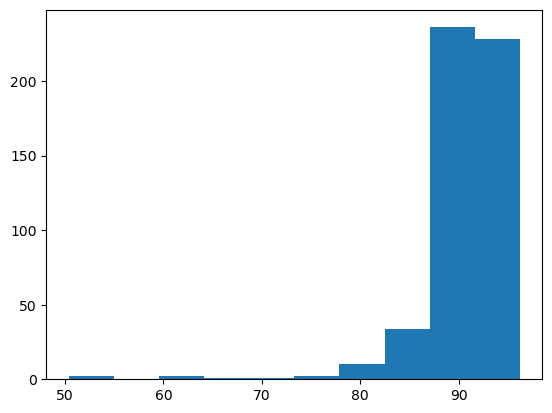

In [11]:
fires = fires[fires['FFMC'] >= 25]
plt.hist(fires['FFMC'])
plt.show()

## DMC 

In [12]:
print(fires['DMC'].isnull().sum())

21


`DMC` column contains 21 null values. Let's examine those closer.

In [13]:
dmc_nulls = fires[fires['DMC'].isnull()]
dmc_nulls

,X,Y,month,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
2,7,4,10,0,90.600000,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.00
19,6,4,3,0,89.200000,NaN,70.8,6.3,15.9,35.0,4.0,0.0,0.00
38,7,4,10,1,90.580384,NaN,682.6,8.7,11.3,60.0,5.4,0.0,0.00
51,4,4,9,0,92.900000,NaN,706.4,9.2,20.8,17.0,1.3,0.0,0.00
53,4,3,8,0,92.100000,NaN,654.1,9.6,20.4,42.0,4.9,0.0,0.00
112,3,4,3,1,91.700000,NaN,77.5,9.0,18.8,NaN,4.5,0.0,0.00
129,3,5,10,0,91.400000,NaN,673.8,5.2,15.9,46.0,3.6,0.0,0.00
196,2,5,8,1,93.900000,NaN,586.7,15.1,23.5,36.0,5.4,0.0,10.02
219,4,5,9,0,92.900000,NaN,699.6,9.2,19.4,19.0,1.3,0.0,31.72
221,8,6,8,1,90.200000,NaN,631.2,6.3,16.2,59.0,3.1,NaN,32.07


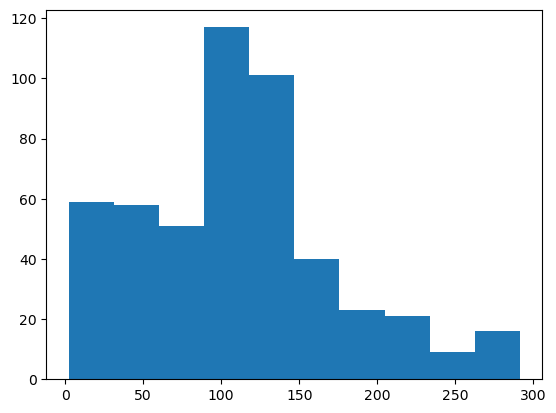

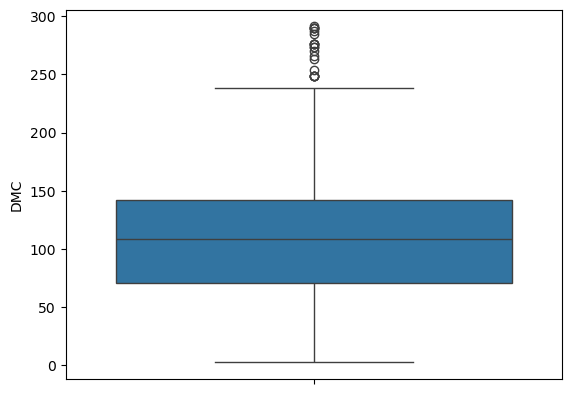

In [14]:
plt.hist(fires['DMC'])
plt.show()
sns.boxplot(data=fires['DMC'])
plt.show()

The `DMC` column also has multiple outliers. The null rows seem to be containing correct data for other columns so we are again going to replace null values with the mean value of `DMC`. We will not deal with outliers at least for now, because there are multiple outliers within the same range, so removing them would remove a lot of our data.

In [15]:
fires['DMC'] = fires['DMC'].fillna(fires['DMC'].mean())
print(fires['DMC'].isnull().sum())

0


## DC

43


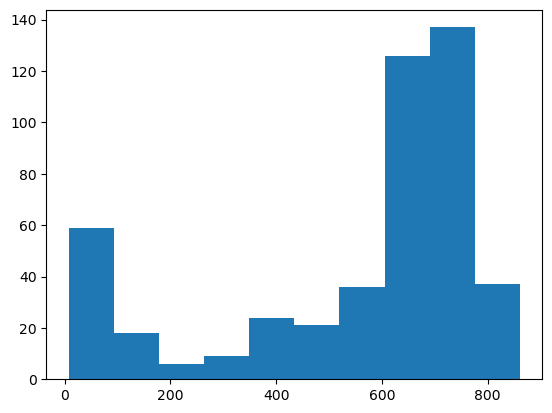

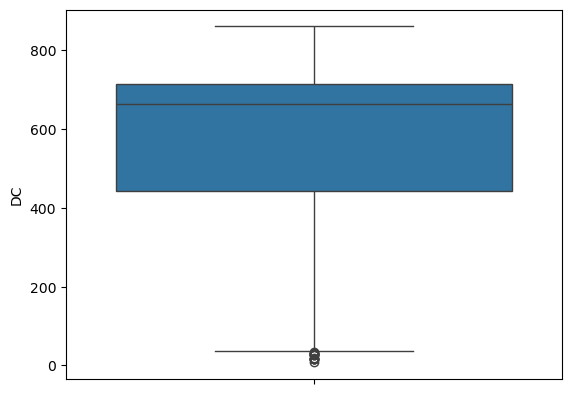

In [16]:
print(fires['DC'].isnull().sum())
plt.hist(fires['DC'])
plt.show()
sns.boxplot(fires['DC'])
plt.show()

With the `DC` column we have 43 null values. From the histogram and boxplot we can see that there are multiple outliers and values that are less than 100. In this case, I won't fill null values with mean, but I will be using median values instead. The median will be closer to the range between 600-800, which seems more appropriate.

In [17]:
print(fires['DC'].mean())
print(fires['DC'].median())
fires['DC'] = fires['DC'].fillna(fires['DC'].median())

551.4752642706131
664.5


## ISI

In [18]:
print(fires['ISI'].isnull().sum())

2


In [19]:
fires[fires['ISI'].isnull()]

,X,Y,month,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
143,8,6,8,1,90.1,108.0,529.8,NaN,21.2,51.0,8.9,0.0,0.61
174,4,4,9,0,90.9,126.5,686.5,NaN,17.7,39.0,NaN,0.0,3.07


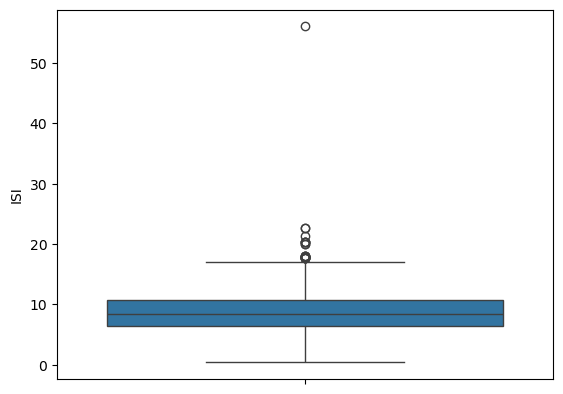

In [20]:
sns.boxplot(fires['ISI'])
plt.show()

In [21]:
fires['ISI'].mean()

9.036381322957197

In the `ISI` column we have two null values. We could remove these without affecting our data much, but I will follow the previous methods and impute them with the mean. However we have one very clear outlier, with a value somewhere close to 60. We will remove this outlier.

In [22]:
fires['ISI'] = fires['ISI'].fillna(fires['ISI'].mean())
fires = fires[fires['ISI'] < 50]

## temp

21


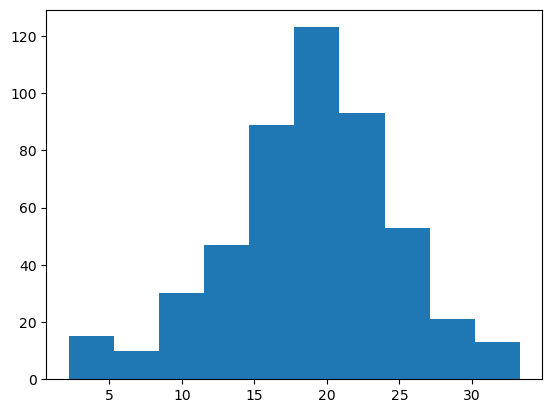

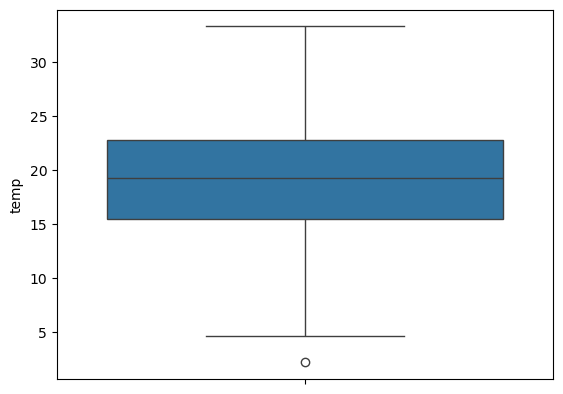

In [23]:
print(fires['temp'].isnull().sum())
plt.hist(fires['temp'])
plt.show()
sns.boxplot(fires['temp'])
plt.show()

The `temp` column is close to a normal distribution and has only one outlier. The outlier is around 2 degrees celsius which is completely normal weather. We won't remove the outlier for now. We will assign mean values to null values.

In [24]:
fires['temp'] = fires['temp'].fillna(fires['temp'].mean())

## RH

30


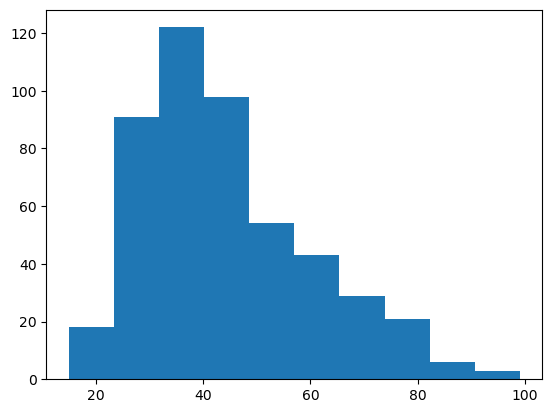

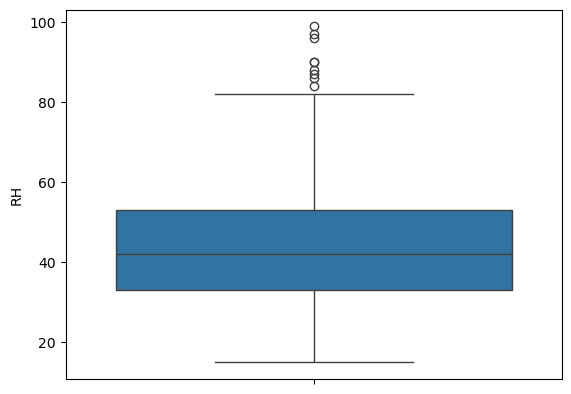

In [25]:
print(fires['RH'].isnull().sum())
plt.hist(fires['RH'])
plt.show()
sns.boxplot(fires['RH'])
plt.show()

The `RH` column is right skewed. This time I will again impute with median value instead of the mean value, because the median is closer to the highest point of distribution (around 40). In this case the mean and the median are both very close to each other, but median value is 42 while the mean value is 44. There are again some outliers, but they are not extreme and there are multiple of them, so we are not going to remove them for now.

In [26]:
print(fires['RH'].mean())
print(fires['RH'].median())

44.2680412371134
42.0


In [27]:
fires['RH'] = fires['RH'].fillna(fires['RH'].median())

## Wind

35


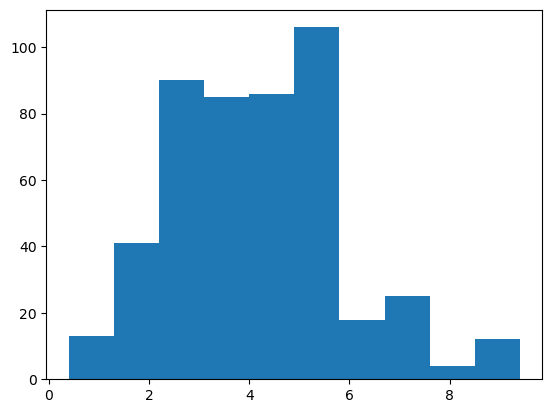

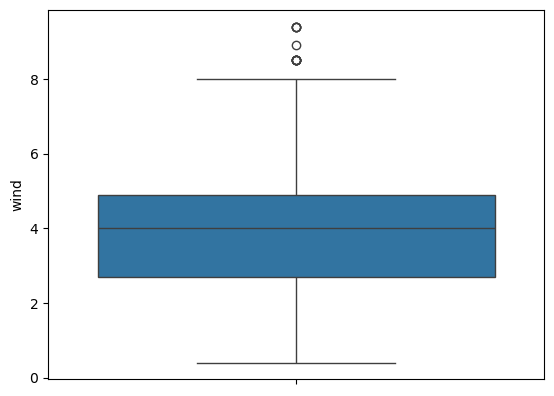

In [28]:
print(fires['wind'].isnull().sum())
plt.hist(fires['wind'])
plt.show()
sns.boxplot(fires['wind'])
plt.show()

Again we have a few outliers, but we won't remove them for now, because 10m/s wind is very possible. The distribution is not normal and slighty right skewed, so we could use mean or median values to fill nulls. Let's see what they are.

In [29]:
print(fires['wind'].mean())
print(fires['wind'].median())
fires['wind'] = fires['wind'].fillna(fires['wind'].mean())

4.027291666666667
4.0


The mean value for `wind` is 4.02, and the median value is 4.0, so they are basically the same. Let's fill the null values with mean values.

## Rain

32


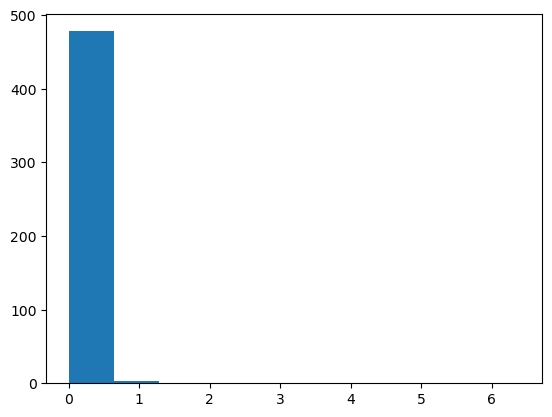

rain
0.0    475
0.2      2
0.8      2
1.0      1
6.4      1
0.4      1
1.4      1
Name: count, dtype: int64


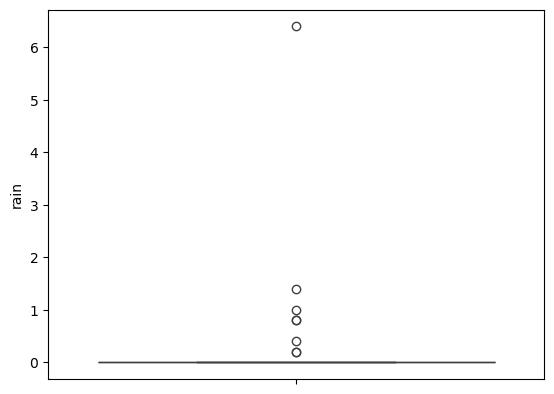

In [30]:
print(fires['rain'].isnull().sum())
plt.hist(fires['rain'])
plt.show()
print(fires['rain'].value_counts())
sns.boxplot(fires['rain'])
plt.show()

Now this one is quite tricky, because almost always the value for rain is `0.0`, meaning no rain, but there are also other values with a some rain close to 0.0. 6.4 is a clear outlier, so we are going to remove it. In fact, from the boxplot all values except 0.0 seem to be outliers, but we will only delete the extreme one. I think the best solution here is to change null values to 0.0 because I don't think there will be a huge difference in the model whether we change null values to 0.0 or 0.1 or 0.2, so let's just move on with 0.0.

In [31]:
fires['rain'] = fires['rain'].fillna(0.0)
fires = fires[fires['rain'] < 5]

## Area

In [32]:
print(fires['area'].isnull().sum())

0


Gladly the column we are interested in predicting has 0 null values. Let's check out the distribution.

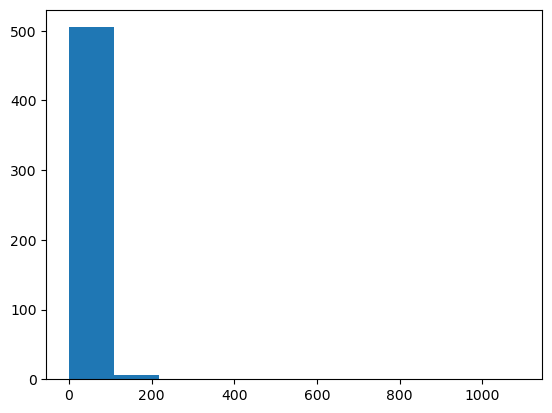

In [33]:
plt.hist(fires['area'])
plt.show()

This is very skewed towards 0.0 and as the documentation suggests it may make sense to model with the logarithm transform. So let's transform the area column with logarithm.

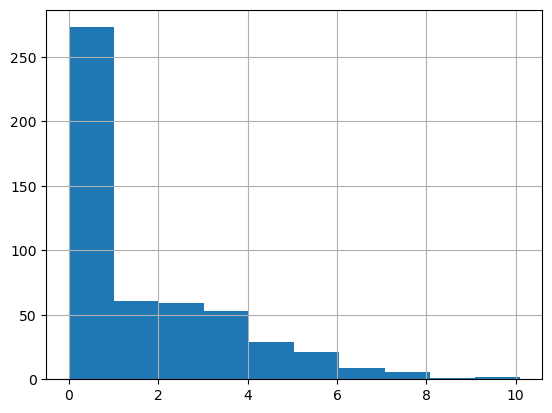

In [34]:
fires['log_area'] = np.log2(fires['area']+1)
fires['log_area'].hist()
plt.show()

The `log_area` column is also very right skewed, but with logarithmic transform there is clearly improvement in the distribution.

## Heatmap

Talking of fires, let's create a heatmap to see which columns correlate most with the `area` column.

Interestingly none of the columns correlate with the `area` column. Let's start modeling anyway.

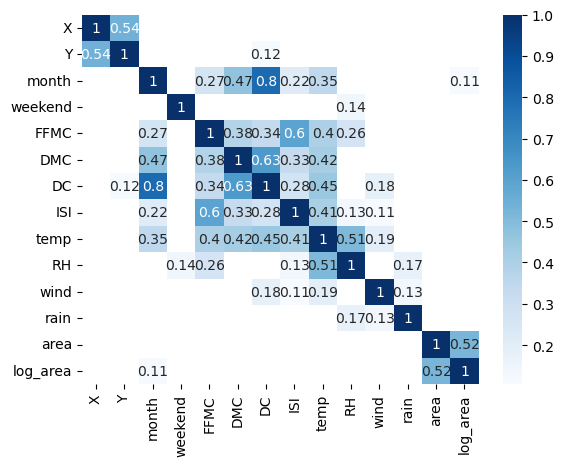

In [35]:
correlations = abs(fires.corr())

sns.heatmap(correlations[correlations > 0.1], annot=True, cmap='Blues')
plt.show()

Interestingly none of the columns have correlation with area. Let's create our reference model using Linear Regression.

In [36]:
ref_model = LinearRegression()


Next we are going to standardize all the values using `sklearn`'s `StandardScaler`. I won't scale X and Y nor the area columns.

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(fires.iloc[:,2:12])
scaled = pd.DataFrame(scaled, columns = fires.iloc[:,2:12].columns)
scaled.head()

,month,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-1.985657,0.980730,-1.022874,-1.360767,-1.971344,-0.949604,0.002918,0.444425,1.546021,-0.100532
1,1.109834,-1.019648,-0.025610,0.001697,0.454632,-0.553376,-0.159370,-0.714814,-1.806843,-0.100532
2,1.109834,0.980730,-0.025610,-1.080977,0.435217,-0.553376,-0.766989,-0.714814,-1.575611,-0.100532
3,-1.985657,0.980730,0.223706,-1.247252,-2.042249,0.016201,-1.892871,3.406925,-0.014795,2.052528
4,-1.985657,0.980730,-0.320256,-0.959468,-1.938001,0.164787,-1.338865,3.535729,0.000982,-0.100532


## Subset Selection

We are now going to select a few features using `sklearn`'s `SequentialFeatureSelector`. As mentioned earlier, we will be using Linear Regression as our reference model. We will split our data to 80% training set and 20% testing set.

In [38]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = scaled
y = fires['log_area']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(411, 10) (103, 10) (411,) (103,)


### Forward Selection

In [39]:
seq_for_2 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 2,
                                      direction='forward')
seq_for_3 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 3,
                                      direction='forward')
seq_for_5 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 5,
                                      direction='forward')
seq_for_2.fit(X_train, y_train)
seq_for_3.fit(X_train, y_train)
seq_for_5.fit(X_train, y_train)

feature_names = X.columns

selected_2_features_forward = feature_names[seq_for_2.get_support()]
selected_3_features_forward = feature_names[seq_for_3.get_support()]
selected_5_features_forward = feature_names[seq_for_5.get_support()]

print(f"With 2 features: {selected_2_features_forward}")
print(f"With 3 features: {selected_3_features_forward}")
print(f"With 3 features: {selected_5_features_forward}")

With 2 features: Index(['month', 'wind'], dtype='object')
With 3 features: Index(['month', 'wind', 'rain'], dtype='object')
With 3 features: Index(['month', 'DMC', 'DC', 'wind', 'rain'], dtype='object')


### Backward Selection

In [40]:
seq_back_2 = SequentialFeatureSelector(ref_model,
                                       n_features_to_select = 2,
                                       direction = 'backward')
seq_back_3 = SequentialFeatureSelector(ref_model,
                                       n_features_to_select = 3,
                                       direction = 'backward')
seq_back_5 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 5,
                                      direction='backward')
seq_back_2.fit(X_train, y_train)
seq_back_3.fit(X_train, y_train)
seq_back_5.fit(X_train, y_train)

selected_2_features_backward = feature_names[seq_back_2.get_support()]
selected_3_features_backward = feature_names[seq_back_3.get_support()]
selected_5_features_backward = feature_names[seq_back_5.get_support()]

print(f"With 2 features: {selected_2_features_backward}")
print(f"With 3 features: {selected_3_features_backward}")
print(f"With 3 features: {selected_5_features_backward}")

With 2 features: Index(['month', 'wind'], dtype='object')
With 3 features: Index(['month', 'wind', 'rain'], dtype='object')
With 3 features: Index(['month', 'DMC', 'DC', 'wind', 'rain'], dtype='object')


Both of these selections give the same features. I will now use logarithmic transform for rain, and change months to summer (yes/no) to see if there are any differences.

## Changing the Month Column

Next we are going to change the `month` column to contain 1 or 0 depending whether it is summer or not. While most of the fires occured during August and September, I think it's better to change `months` to `summer`, because now `month` is one of the most dominating features. I think our model would be better without all the months. If we want to predict fires during April for example, the model should not be dominated by August and September.

I will use months June, July and August (6, 7 and 8)for summer.

In [41]:
fires['month'] = fires['month'].apply(lambda x: 1 if x in (6, 7, 8) else 0)
fires = fires.rename(columns={'month': 'summer'})
fires.head()

,X,Y,summer,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
1,7,5,0,1,86.2,26.200000,94.3,5.1,18.908097,51.0,6.700000,0.0,0.0,0.0
2,7,4,0,0,90.6,111.417778,669.1,6.7,18.000000,33.0,0.900000,0.0,0.0,0.0
3,7,4,0,1,90.6,43.700000,664.5,6.7,14.600000,33.0,1.300000,0.0,0.0,0.0
4,8,6,0,1,91.7,33.300000,77.5,9.0,8.300000,97.0,4.000000,0.2,0.0,0.0
5,8,6,0,1,89.3,51.300000,102.2,9.6,11.400000,99.0,4.027292,0.0,0.0,0.0


I also think that columns X and Y don't really provice any valuable information, if we want to predict the area in a completely different coordinates, so I will remove those from the final dataset.

In [42]:
fires = fires.drop(columns=['X', 'Y'])
fires.head()

,summer,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
1,0,1,86.2,26.200000,94.3,5.1,18.908097,51.0,6.700000,0.0,0.0,0.0
2,0,0,90.6,111.417778,669.1,6.7,18.000000,33.0,0.900000,0.0,0.0,0.0
3,0,1,90.6,43.700000,664.5,6.7,14.600000,33.0,1.300000,0.0,0.0,0.0
4,0,1,91.7,33.300000,77.5,9.0,8.300000,97.0,4.000000,0.2,0.0,0.0
5,0,1,89.3,51.300000,102.2,9.6,11.400000,99.0,4.027292,0.0,0.0,0.0


Now that we have modified our data, let's scale it again and select the features.

### Scaling

In [43]:
#no need to scale summer and weekend, cause they are 0 and 1
#not scaling areas
final_scaled = scaler.fit_transform(fires.iloc[:,2:10])
final_scaled = pd.DataFrame(final_scaled, columns = fires.iloc[:,2:10].columns)
weekend_summer_df = fires.iloc[:,:2]
final_scaled.index = weekend_summer_df.index
final_df = pd.concat([weekend_summer_df, final_scaled], axis=1)
final_df.head()

,summer,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain
1,0,1,-1.022874,-1.360767,-1.971344,-0.949604,0.002918,0.444425,1.546021,-0.100532
2,0,0,-0.025610,0.001697,0.454632,-0.553376,-0.159370,-0.714814,-1.806843,-0.100532
3,0,1,-0.025610,-1.080977,0.435217,-0.553376,-0.766989,-0.714814,-1.575611,-0.100532
4,0,1,0.223706,-1.247252,-2.042249,0.016201,-1.892871,3.406925,-0.014795,2.052528
5,0,1,-0.320256,-0.959468,-1.938001,0.164787,-1.338865,3.535729,0.000982,-0.100532


In [44]:
X = final_df
y = fires['log_area']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(411, 10) (103, 10) (411,) (103,)


### Forward Selection

In [45]:
seq_for_2 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 2,
                                      direction='forward')
seq_for_3 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 3,
                                      direction='forward')
seq_for_5 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 5,
                                      direction='forward')
seq_for_2.fit(X_train, y_train)
seq_for_3.fit(X_train, y_train)
seq_for_5.fit(X_train, y_train)

feature_names = X.columns

selected_2_features_forward = feature_names[seq_for_2.get_support()]
selected_3_features_forward = feature_names[seq_for_3.get_support()]
selected_5_features_forward = feature_names[seq_for_5.get_support()]

print(f"With 2 features: {selected_2_features_forward}")
print(f"With 3 features: {selected_3_features_forward}")
print(f"With 3 features: {selected_5_features_forward}")

With 2 features: Index(['DMC', 'wind'], dtype='object')
With 3 features: Index(['summer', 'DMC', 'wind'], dtype='object')
With 3 features: Index(['summer', 'DMC', 'DC', 'wind', 'rain'], dtype='object')


### Backward Selection

In [46]:
seq_back_2 = SequentialFeatureSelector(ref_model,
                                       n_features_to_select = 2,
                                       direction = 'backward')
seq_back_3 = SequentialFeatureSelector(ref_model,
                                       n_features_to_select = 3,
                                       direction = 'backward')
seq_back_5 = SequentialFeatureSelector(ref_model,
                                      n_features_to_select = 5,
                                      direction='backward')
seq_back_2.fit(X_train, y_train)
seq_back_3.fit(X_train, y_train)
seq_back_5.fit(X_train, y_train)

print("Features selected in 2 feature model:", seq_back_2.get_feature_names_out())
print("Features selected in 3 feature model:", seq_back_3.get_feature_names_out())
print("Features selected in 5 feature model:", seq_back_5.get_feature_names_out())

Features selected in 2 feature model: ['DMC' 'wind']
Features selected in 3 feature model: ['summer' 'DMC' 'wind']
Features selected in 5 feature model: ['summer' 'DMC' 'DC' 'wind' 'rain']


Again both of the selection methods have same features. `summer`, `DMC` and `wind` seem to be top 3 features.

## Assigning Models

In [47]:
fw2_model = LinearRegression() 
fw2_model.fit(final_df[seq_for_2.get_feature_names_out()], y)
fw3_model = LinearRegression() 
fw3_model.fit(final_df[seq_for_3.get_feature_names_out()], y)
fw5_model = LinearRegression() 
fw5_model.fit(final_df[seq_for_5.get_feature_names_out()], y)

LinearRegression()

# More Candidate Models

Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. Next we are going to add ridge and LASSO models.

In [48]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final_df, y)
lasso.fit(final_df, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  681.6126126126127
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.0400243   0.00150899  0.01991369  0.05086245  0.04544588 -0.01918611
  0.01535969 -0.03612795  0.06221562 -0.05141238]
LASSO coefficients:  [-0.  0.  0.  0.  0.  0.  0. -0.  0. -0.]


The Ridge tuning parameter is approximately 681.61. This parameter applies a moderate level of regularization to the model, shrinking the coefficients to prevent overfitting but still allowing them to retain some influence. The coefficients tell us how much each feature affects `log_area`.

The LASSO tuning parameter always seems to get the highest value possible. It doesn't matter if we change the maximum to 100000 or even 1000000, it will always be the highest value. Because of this the coefficients are 0.

From the coefficients we can see that they are all close to 0. Because LASSO coefficients are 0, this would mean that the model performs better with no features.

We will use the Ridge turning parameter next in k-fold cross-validation.

## K-Fold Cross-Validation

Now that we have few linear regression models, a ridge model and a lasso model, let's evaluate all of them using k-fold cross-validation. We will be using `k=5`, because it is a good compromise between bias and variance. We will now iterate through all the models and check their mean squared error values.

In [49]:
from sklearn.model_selection import cross_val_score

#Let's use wind and temp for reference model
ref_cv = cross_val_score(ref_model, final_df[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final_df[seq_for_2.get_feature_names_out()], y, cv=5, scoring = "neg_mean_squared_error")
fw3_cv = cross_val_score(fw3_model, final_df[seq_for_3.get_feature_names_out()], y, cv=5, scoring = "neg_mean_squared_error")
fw5_cv = cross_val_score(fw5_model, final_df[seq_for_5.get_feature_names_out()], y, cv=5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final_df, y, cv = 5, scoring ='neg_mean_squared_error')

In [50]:
print("Reference Model, Avg Test MSE: ", np.mean(ref_cv), " SD: ", np.std(ref_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw3_cv), " SD: ", np.std(fw3_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw5_cv), " SD: ", np.std(fw5_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(ridge_cv), " SD: ", np.std(ridge_cv))

Reference Model, Avg Test MSE:  -4.599076499977356  SD:  2.2450503685910617
Forward-2 Model, Avg Test MSE:  -4.616953308837746  SD:  2.2113555954120594
Forward-4 Model, Avg Test MSE:  -4.7000157167736045  SD:  2.2146763531901037
Forward-6 Model, Avg Test MSE:  -4.719151483181365  SD:  2.1971438588072756
Ridge Model, Avg Test MSE:  -4.72868707874945  SD:  2.224520743217394


According to mean squared error values, the ridge model performs best (lowest mse value). However all the models perform almost the same. These are the `log_area` values, so if we change them to original scale the MSE would be around 25, which is fairly bad. These models overall are not good predictors.

We could try to improve these models by deleting all the null values that we imputed with mean or median values. However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. The point of this project was to showcase that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.